In [4]:
import os
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
from pytorch_tabnet.tab_model import TabNetClassifier

In [5]:
train = pd.read_csv('..\\data\\census\\census-income.data',header=None)
pd.set_option('display.max_columns', None)
train

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41
0,73,Not in universe,0,0,High school graduate,0,Not in universe,Widowed,Not in universe or children,Not in universe,White,All other,Female,Not in universe,Not in universe,Not in labor force,0,0,0,Nonfiler,Not in universe,Not in universe,Other Rel 18+ ever marr not in subfamily,Other relative of householder,1700.09,?,?,?,Not in universe under 1 year old,?,0,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,- 50000.
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,White,All other,Male,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Head of household,South,Arkansas,Householder,Householder,1053.55,MSA to MSA,Same county,Same county,No,Yes,1,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,- 50000.
2,18,Not in universe,0,0,10th grade,0,High school,Never married,Not in universe or children,Not in universe,Asian or Pacific Islander,All other,Female,Not in universe,Not in universe,Not in labor force,0,0,0,Nonfiler,Not in universe,Not in universe,Child 18+ never marr Not in a subfamily,Child 18 or older,991.95,?,?,?,Not in universe under 1 year old,?,0,Not in universe,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,Not in universe,2,0,95,- 50000.
3,9,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,White,All other,Female,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Nonfiler,Not in universe,Not in universe,Child <18 never marr not in subfamily,Child under 18 never married,1758.14,Nonmover,Nonmover,Nonmover,Yes,Not in universe,0,Both parents present,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.
4,10,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,White,All other,Female,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Nonfiler,Not in universe,Not in universe,Child <18 never marr not in subfamily,Child under 18 never married,1069.16,Nonmover,Nonmover,Nonmover,Yes,Not in universe,0,Both parents present,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199518,87,Not in universe,0,0,7th and 8th grade,0,Not in universe,Married-civilian spouse present,Not in universe or children,Not in universe,White,All other,Male,Not in universe,Not in universe,Not in labor force,0,0,0,Joint both 65+,Not in universe,Not in universe,Householder,Householder,955.27,?,?,?,Not in universe under 1 year old,?,0,Not in universe,Canada,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,- 50000.
199519,65,Self-employed-incorporated,37,2,11th grade,0,Not in universe,Married-civilian spouse present,Business and repair services,Executive admin and managerial,White,All other,Male,Not in universe,Not in universe,Children or Armed Forces,6418,0,9,Joint one under 65 & one 65+,Not in universe,Not in universe,Householder,Householder,687.19,Nonmover,Nonmover,Nonmover,Yes,Not in universe,1,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,- 50000.
199520,47,Not in universe,0,0,Some college but no degree,0,Not in universe,Married-civilian spouse present,Not in universe or children,Not in universe,White,All other,Male,Not in universe,Not in universe,Children or Armed Forces,0,0,157,Joint both under 65,Not in universe,Not in universe,Householder,Householder,1923.03,?,?,?,Not in u

In [6]:
target = 41    # 41번째 컬럼
if "Set" not in train.columns:
    train["Set"] = np.random.choice(["train", "valid", "test"], p =[.8, .1, .1], size=(train.shape[0],))

train_indices = train[train.Set=="train"].index
valid_indices = train[train.Set=="valid"].index
test_indices = train[train.Set=="test"].index

In [7]:
nunique = train.nunique()
types = train.dtypes

categorical_columns = []
categorical_dims =  {}
for col in train.columns:
    if types[col] == 'object' or nunique[col] < 200:
        print(col, train[col].nunique())
        l_enc = LabelEncoder()
        train[col] = train[col].fillna("VV_likely")
        train[col] = l_enc.fit_transform(train[col].values)
        categorical_columns.append(col)
        categorical_dims[col] = len(l_enc.classes_)
    else:
        train.fillna(train.loc[train_indices, col].mean(), inplace=True)


# Categorical Embedding을 위해 Categorical 변수의 차원과 idxs를 담음.
unused_feat = ['Set']
features = [ col for col in train.columns if col not in unused_feat+[target]] 
cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]
cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]



X_train = train[features].values[train_indices]
y_train = train[target].values[train_indices]

X_valid = train[features].values[valid_indices]
y_valid = train[target].values[valid_indices]

X_test = train[features].values[test_indices]
y_test = train[target].values[test_indices]

0 91
1 9
2 52
3 47
4 17
6 3
7 7
8 24
9 15
10 5
11 10
12 2
13 3
14 6
15 8
16 132
17 113
19 6
20 6
21 51
22 38
23 8
25 10
26 9
27 10
28 3
29 4
30 7
31 5
32 43
33 43
34 43
35 5
36 3
37 3
38 3
39 53
40 2
41 2
Set 3


In [14]:
cat_idxs

[0,
 1,
 2,
 3,
 4,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 19,
 20,
 21,
 22,
 23,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40]

In [8]:
clf = TabNetClassifier(cat_idxs=cat_idxs,
                       cat_dims=cat_dims,
                       cat_emb_dim=10,
                       optimizer_fn=torch.optim.Adam,
                       optimizer_params=dict(lr=1e-2),
                       scheduler_params={"step_size":50,
                                         "gamma":0.9},
                       scheduler_fn=torch.optim.lr_scheduler.StepLR,
                       mask_type='sparsemax' # "sparsemax", entmax
                      )

Device used : cuda


In [9]:
max_epochs = 15

clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_name=['train', 'valid'],
    eval_metric=['auc'],
    max_epochs=max_epochs , patience=20,
    batch_size=1024, virtual_batch_size=128,
    num_workers=0,
    weights=1,
    drop_last=False,
)

epoch 0  | loss: 0.52056 | train_auc: 0.87989 | valid_auc: 0.87613 |  0:00:10s
epoch 1  | loss: 0.39421 | train_auc: 0.92078 | valid_auc: 0.91286 |  0:00:19s
epoch 2  | loss: 0.34559 | train_auc: 0.93236 | valid_auc: 0.92671 |  0:00:29s
epoch 3  | loss: 0.32196 | train_auc: 0.93675 | valid_auc: 0.92826 |  0:00:38s
epoch 4  | loss: 0.30597 | train_auc: 0.94552 | valid_auc: 0.93629 |  0:00:48s
epoch 5  | loss: 0.29576 | train_auc: 0.95002 | valid_auc: 0.94122 |  0:00:57s
epoch 6  | loss: 0.28124 | train_auc: 0.95355 | valid_auc: 0.94211 |  0:01:06s
epoch 7  | loss: 0.27309 | train_auc: 0.95681 | valid_auc: 0.94431 |  0:01:16s
epoch 8  | loss: 0.26554 | train_auc: 0.95779 | valid_auc: 0.94572 |  0:01:24s
epoch 9  | loss: 0.26055 | train_auc: 0.96047 | valid_auc: 0.9441  |  0:01:33s
epoch 10 | loss: 0.2522  | train_auc: 0.96203 | valid_auc: 0.94385 |  0:01:42s
epoch 11 | loss: 0.24908 | train_auc: 0.96217 | valid_auc: 0.9419  |  0:01:52s
epoch 12 | loss: 0.2455  | train_auc: 0.96477 | vali

In [10]:
preds = clf.predict_proba(X_test)
test_auc = roc_auc_score(y_score=preds[:,1], y_true=y_test)

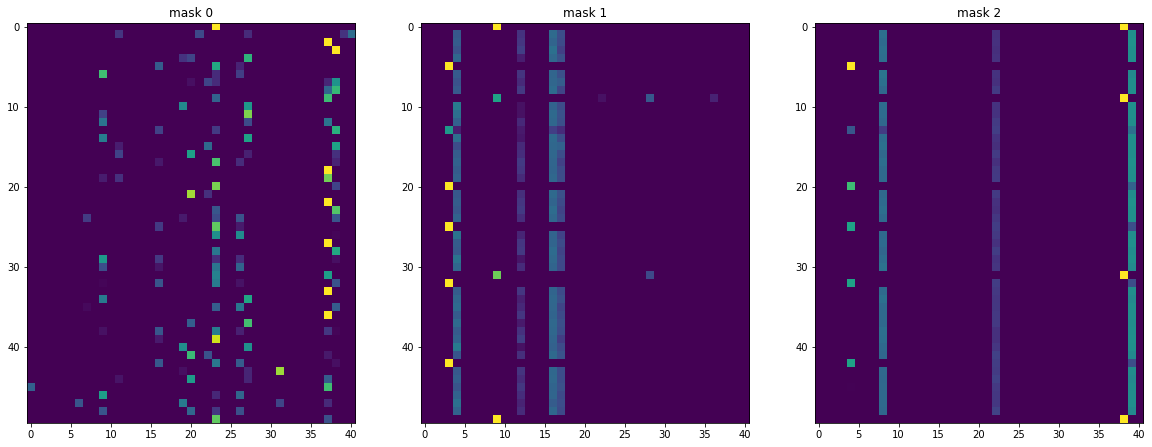

In [11]:
explain_matrix, masks = clf.explain(X_test)

fig, axs = plt.subplots(1, 3, figsize=(20,20))
for i in range(3):
    axs[i].imshow(masks[i][:50])
    axs[i].set_title(f"mask {i}")